## Topic Coherence
Based on http://qpleple.com/topic-coherence-to-evaluate-topic-models/


In [1]:
import numpy as np
from scipy.sparse import csr_matrix

class TopicCoherence(object):
    '''
    Based on the information here: http://qpleple.com/topic-coherence-to-evaluate-topic-models/
    Calculating the topic coherence for LDA through sklearn, rather than through Gensim
    
    ATTRIBUTES
    D: Gives the Document counts, with D(wi) on the diagonal and D(wi,wj) as i,j
    p: Gives the probabilities, with p(wi) on the diagonal and the rest as p(wi,wj)
    vocabulary: saved the vocabulary from the fit, so we know what word is what
    UCI_score: UCI Score (wi,wj)
    UMass_score: UMass Score(wi,wj)
    
    METHODS:
    fit(vocabulary, documents): Creates the Document Counts and the probability
        counts for the corpus and vectorizer used.
        vocabulary: CountVectorizer.vocabulary_
        documents: the raw documents used, based on what was put into
                    the count vectorizer.
     
    
    Darin LaSota, 2/7/2019
    
    '''
    def __init__(self,words=10,score='both'):
        '''
        Initializer.
        '''
        self.words_to_use = words
        self.score = score

    def fit(self, vocabulary, transformed_docs, verbose=False, noise=True):
        '''
        This is to get the various document probabilities, likely because these will be the same 
        for all models if running this in a grid_search
        '''
        if noise == True:
            noise = 0.000000000000000000000000000000000000000000001
        else:
            noise = 0
        if verbose:
            print('Starting...')
        self.vocabulary = vocabulary  # save for later
        self.docs_words = transformed_docs > 0
        self.docs_words = self.docs_words*1.0
        self.Di = np.sum(self.docs_words,0)
        if verbose:
            print('Di done')
        self.Dij = self.docs_words.transpose() * self.docs_words
        if verbose:
            print('Dij done')       
        self.pi = self.Di/transformed_docs.shape[0]
        self.pij = self.Dij/transformed_docs.shape[0]
        if verbose:
            print('pi and pij done')
        # save the scores as made, to avoid redunency
        self.UCI_score = csr_matrix(self.Dij.shape)
        self.UMass_score = csr_matrix(self.Dij.shape)
    
    def UCI(self,i,j):
        '''
        Calculates the following:
                score(wi,wj) = log(1 + p(wi,wj)/p(wi)p(wj))
        Added the smoothing factor of 1 to keep results positive (and not heading toward 
        negative infinity)
        '''
        if i>j:
            a = i
            i = j
            j = a
        if self.UCI_score[i,j] == 0:
            self.UCI_score[i,j] = np.log(1 + self.pij[i,j]/(self.pi[0,i]*self.pi[0,j]))
        return self.UCI_score[i,j]
                      
    def UMass(self,i,j):
        '''
        Calculates the following:
            score(wi,wj) = log(1 + D[wi,wj]/D[wi])
        
        '''
        if self.UMass_score[i,j] == 0:
            self.UMass_score[i,j] = np.log(1+self.Dij[i,j]/self.Di[0,i])
        return self.UMass_score[i,j]
        
    def tc_score(self,model,X,y=[]):
        score = []
        for topic_weights in model.components_:
            top_keyword_locs = (-topic_weights).argsort()[:self.words_to_use]
            for word in top_keyword_locs:
                if self.score == 'UCI' or self.score == 'both':
                    uci = np.mean([self.UCI(word,a) for a in  top_keyword_locs if a != word])
                if self.score == 'UMass' or self.score == 'both':
                    umass = np.mean([self.UMass(word,a) for a in  top_keyword_locs if a != word])
                if self.score == 'Umass':
                    score.append(umass)
                elif self.score == 'UCI':
                    score.append(uci)
                else:
                    score.append(uci*umass)

        return np.mean(score)

In [2]:
# Data import on its own line
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import re, nltk, gensim, spacy
from nltk.stem import WordNetLemmatizer
import pandas as pd


df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))



def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
count_vector = data_vectorized
print(count_vector.shape)

C:\Users\Darin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(11314, 65012)


In [3]:
Topic_Coherence = TopicCoherence()
Topic_Coherence.fit(vectorizer.vocabulary, data_vectorized,True)

Starting...
Di done
Dij done
pi and pij done


In [4]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    plt.show()

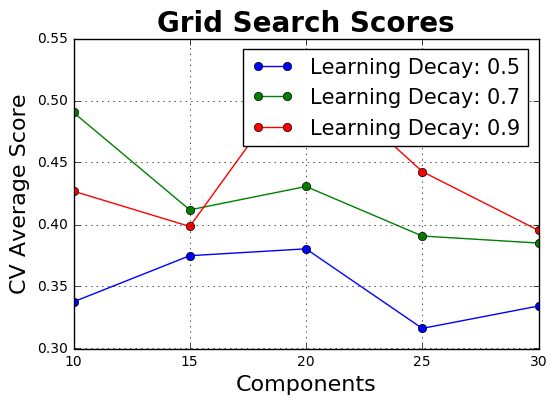

In [8]:
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation


warnings.filterwarnings("ignore")
params = {'n_components':[10,15,20,25,30] 
         , 'learning_decay':[0.5,0.7,0.9]}
model =  LatentDirichletAllocation()
gs = GridSearchCV(model,params,cv=5,scoring=Topic_Coherence.tc_score)
gs.fit(count_vector)

plot_grid_search(gs.cv_results_, params['n_components'], params['learning_decay'], 'Components', 'Learning Decay')

In [9]:
import pyLDAvis
import pyLDAvis.sklearn

print(gs.best_params_)
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(gs.best_estimator_, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.display(panel)

{'learning_decay': 0.9, 'n_components': 20}


In [20]:
from sklearn.metrics import silhouette_score

def silhouette_scoring(model, X, y=[]):
    return silhouette_score(X, model.predict(X))

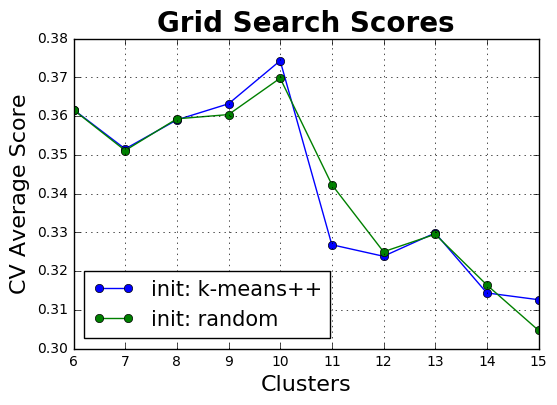

In [24]:
from sklearn.cluster import KMeans
kparams = {'n_clusters':[6 + a for a in range(10)]
          , 'init':['k-means++', 'random']}
km = KMeans()
gk = GridSearchCV(km,kparams,cv=5, scoring=silhouette_scoring)
gk.fit(gs.best_estimator_.transform(data_vectorized))

plot_grid_search(gk.cv_results_, kparams['n_clusters'], kparams['init'], 'Clusters', 'init')